In [34]:
# !pip install pyunpack
# !pip install patool

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# from pyunpack import Archive
# Archive('/content/drive/My Drive/Data_Set_2(Black_and_white_images).rar').extractall('/content/drive/My Drive/Data_Set_2(Black_and_white_images)')

In [117]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pickle

In [38]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.data = []
        self.filename = filename
        tar = tarfile.open(folder + '/' + filename)
        for file in tar.getmembers():
            f = tar.extractfile(file)
            if f != None:
                content = pd.read_csv(StringIO(f.read().decode()), sep=' ', header=None).values.ravel()
                self.data.append(content)
            
        self.y = torch.tensor(label_dict[self.filename[:-7]], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [39]:
def train_test_loader(directory, label_dict, train_fraction=0.8, num_workers=2):

    all_files = list(filter(lambda x: x.endswith('.tar.gz'), os.listdir(directory)))
    files = [file for file in all_files if file[:-7] in label_dict.keys()]
    
    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [40]:
label_dict = {
    'tallbuilding': 0,
    'mountain': 1,
    'highway': 2,
    'coast': 3, 
    'opencountry': 4}

trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)

In [41]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
X_train = []
for X, y in trainloader:
  X_train.extend(X.numpy())
X_train = np.array(X_train)

97% Variance Explained: 229


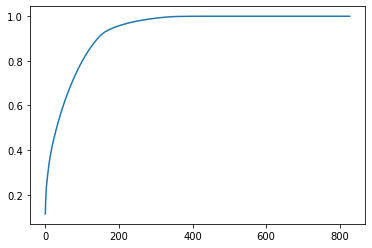

In [44]:
pca1 = PCA(n_components=X_train.shape[1])
pca1.fit(X_train)

print('97% Variance Explained:', np.where(np.cumsum(pca1.explained_variance_ratio_)>=0.97)[0][0]+1)
explained_var = np.cumsum(pca1.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [79]:
criterion = nn.MSELoss()

ae1 = AutoEncoder(828, [400, 200, 400])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.0001, momentum=0.9)

In [80]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    len_ = 0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if (abs(running_loss-old_loss)/running_loss < 1e-5):
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 1.9322659725492646
Epoch 2 : Loss = 1.9119414172389289
Epoch 3 : Loss = 1.8916960385712707
Epoch 4 : Loss = 1.872071848674254
Epoch 5 : Loss = 1.8526994206688627
Epoch 6 : Loss = 1.833146650682796
Epoch 7 : Loss = 1.8131206902590662
Epoch 8 : Loss = 1.7923159165815872
Epoch 9 : Loss = 1.7705351358110255
Epoch 10 : Loss = 1.7475719343532214
Epoch 11 : Loss = 1.7232755232941024
Epoch 12 : Loss = 1.6975687092000793
Epoch 13 : Loss = 1.6703512722795661
Epoch 14 : Loss = 1.6416068293831565
Epoch 15 : Loss = 1.6112863394347108
Epoch 16 : Loss = 1.5794536227529696
Epoch 17 : Loss = 1.5461519631472507
Epoch 18 : Loss = 1.5114889063618397
Epoch 19 : Loss = 1.4754880151965404
Epoch 20 : Loss = 1.4383839260448108
Epoch 21 : Loss = 1.400214138356122
Epoch 22 : Loss = 1.3612529743801465
Epoch 23 : Loss = 1.3216421089389103
Epoch 24 : Loss = 1.281550922177055
Epoch 25 : Loss = 1.2411584799939936
Epoch 26 : Loss = 1.2006559344855219
Epoch 27 : Loss = 1.1602380275726316
Epoch 28 : Los

In [81]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      X_pred = ae1(X)
      loss = criterion(X_pred, X)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.20566899261691352


In [82]:
Z1_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)

    if len(Z1_array) == 0:
        Z1_array = Z1.cpu().numpy()
    else:
        Z1_array = np.append(Z1_array, Z1.cpu().numpy(), axis=0)

97% Variance Explained: 85


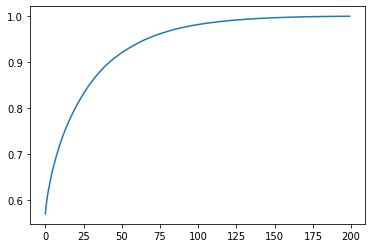

In [83]:
pca2 = PCA(n_components=Z1_array.shape[1])
pca2.fit(Z1_array)
print('97% Variance Explained:', np.where(np.cumsum(pca2.explained_variance_ratio_)>=0.97)[0][0]+1)

explained_var = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [84]:
ae2 = AutoEncoder(200, [150, 75, 150])
optimizer2 = optim.SGD(ae2.parameters(), lr=0.0001, momentum=0.9)
ae2 = ae2.to(device)

In [85]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer2.zero_grad()
        
        # Reconstructed Representation of X (forward)
        Z_hat = ae2(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer2.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-5:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 2.108018495819786
Epoch 2 : Loss = 2.075668237426065
Epoch 3 : Loss = 2.0419576303525404
Epoch 4 : Loss = 2.0073560151186856
Epoch 5 : Loss = 1.9709010882811115
Epoch 6 : Loss = 1.9318041720173573
Epoch 7 : Loss = 1.889410598711534
Epoch 8 : Loss = 1.8432131816040387
Epoch 9 : Loss = 1.792929448864677
Epoch 10 : Loss = 1.738418703729457
Epoch 11 : Loss = 1.6797663461078294
Epoch 12 : Loss = 1.617145549167286
Epoch 13 : Loss = 1.550958955829794
Epoch 14 : Loss = 1.481752287257801
Epoch 15 : Loss = 1.4101453504779122
Epoch 16 : Loss = 1.3368813801895487
Epoch 17 : Loss = 1.2626744481650265
Epoch 18 : Loss = 1.188277060335333
Epoch 19 : Loss = 1.1144099100069567
Epoch 20 : Loss = 1.041731755841862
Epoch 21 : Loss = 0.9707777554338629
Epoch 22 : Loss = 0.9021019542759113
Epoch 23 : Loss = 0.8359965085983275
Epoch 24 : Loss = 0.772885552861474
Epoch 25 : Loss = 0.7128673385490073
Epoch 26 : Loss = 0.6561448154124346
Epoch 27 : Loss = 0.6027738831259988
Epoch 28 : Loss = 0.5

In [86]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z = ae1.get_z(X)
      Z_pred = ae2(Z)
      loss = criterion(Z_pred, Z)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.009037855123593046


In [87]:
Z2_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)
      Z2 = ae2.get_z(Z1)

    if len(Z2_array) == 0:
        Z2_array = Z2.cpu().numpy()
    else:
        Z2_array = np.append(Z2_array, Z2.cpu().numpy(), axis=0)

97% Variance Explained: 13


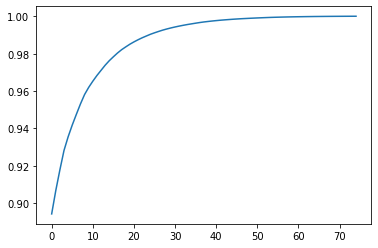

In [88]:
pca3 = PCA(n_components=Z2_array.shape[1])
pca3.fit(Z2_array)
print('97% Variance Explained:', np.where(np.cumsum(pca3.explained_variance_ratio_)>=0.97)[0][0]+1)

explained_var = np.cumsum(pca3.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [91]:
ae3 = AutoEncoder(75, [50, 15, 50])
optimizer3 = optim.SGD(ae3.parameters(), lr=0.0001, momentum=0.9)
ae3 = ae3.to(device)

In [92]:
old_loss = np.inf

max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z1 = ae1.get_z(X)
            Z = ae2.get_z(Z1)
        
        optimizer3.zero_grad()
        
        # Reconstructed Representation of Z (forward)
        Z_hat = ae3(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer3.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-5:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 2.3820965777743948
Epoch 2 : Loss = 2.3099342963912277
Epoch 3 : Loss = 2.240768606012518
Epoch 4 : Loss = 2.17479775168679
Epoch 5 : Loss = 2.1094413670626553
Epoch 6 : Loss = 2.0430152958089653
Epoch 7 : Loss = 1.9745480147275063
Epoch 8 : Loss = 1.9036514433947473
Epoch 9 : Loss = 1.8302678547122266
Epoch 10 : Loss = 1.754635645584627
Epoch 11 : Loss = 1.6771458062258628
Epoch 12 : Loss = 1.5982784574682065
Epoch 13 : Loss = 1.518536239862442
Epoch 14 : Loss = 1.4384969174861908
Epoch 15 : Loss = 1.3586993921886783
Epoch 16 : Loss = 1.2796725820411334
Epoch 17 : Loss = 1.201946513219313
Epoch 18 : Loss = 1.1259492039680483
Epoch 19 : Loss = 1.0521085451949728
Epoch 20 : Loss = 0.9807622825557535
Epoch 21 : Loss = 0.9121949726885015
Epoch 22 : Loss = 0.8466222272677854
Epoch 23 : Loss = 0.7842071015726437
Epoch 24 : Loss = 0.7250346216288482
Epoch 25 : Loss = 0.6691761829636315
Epoch 26 : Loss = 0.616626956246116
Epoch 27 : Loss = 0.5673402168534019
Epoch 28 : Loss =

In [93]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)
      Z = ae2.get_z(Z1)
      Z_pred = ae3(Z)
      loss = criterion(Z_pred, Z)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.0007135829628995534


In [125]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(828, [400, 150, 50, 15], 5)

In [134]:
# ae1_params = list(ae1.parameters())
# ae2_params = list(ae2.parameters())
# ae3_params = list(ae3.parameters())
# pickle.dump((ae1_params, ae2_params, ae3_params), open('/content/drive/My Drive/Ass1Q2_init.sav', 'wb'))

(ae1_params, ae2_params, ae3_params) = pickle.load(open('/content/drive/My Drive/Ass1Q2_init.sav', 'rb'))

with torch.no_grad():
    
    classifier.fc1.weight.data = nn.Parameter(ae1_params[0])
    classifier.fc1.bias.data = nn.Parameter(ae1_params[1])
    
    classifier.fc2.weight = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[2]))
    classifier.fc2.bias = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[3]) + ae2_params[1])
    
    classifier.fc3.weight = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[2]))
    classifier.fc3.bias = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[3]) + ae3_params[1])
    
    classifier.fc4.weight = nn.Parameter(ae3_params[2])
    classifier.fc4.bias = nn.Parameter(ae3_params[3])

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
classifier = classifier.to(device)

In [136]:
old_loss = np.inf

max_epoch = 200

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-3:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 1.7094283212314947
Epoch 2 : Loss = 0.8871442418206821
Epoch 3 : Loss = 0.618906164711172
Epoch 4 : Loss = 0.41890863363038405
Epoch 5 : Loss = 0.3108258223669096
Epoch 6 : Loss = 0.2721154168248176
Epoch 7 : Loss = 0.2220215846530416
Epoch 8 : Loss = 0.2504797132516449
Epoch 9 : Loss = 0.2067782597785647
Epoch 10 : Loss = 0.16732645796781243
Epoch 11 : Loss = 0.15982529961250047
Epoch 12 : Loss = 0.1701343020593578
Epoch 13 : Loss = 0.1697550485418601
Epoch 14 : Loss = 0.1454118038104339
Epoch 15 : Loss = 0.22705053741281678
Epoch 16 : Loss = 0.16264148615300658
Epoch 17 : Loss = 0.14003813080489638
Epoch 18 : Loss = 0.15102741325443444
Epoch 19 : Loss = 0.1318457814102823
Epoch 20 : Loss = 0.14038881659507754
Epoch 21 : Loss = 0.13939036699858576
Epoch 22 : Loss = 0.1377106820317832
Epoch 23 : Loss = 0.11846282180737366
Epoch 24 : Loss = 0.13147930919446732
Epoch 25 : Loss = 0.15264644558456808
Epoch 26 : Loss = 0.20466907051476568
Epoch 27 : Loss = 0.117387736724181

In [137]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
print(pd.DataFrame(confusion_matrix(y_train, y_train_pred)))

acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Loss = 0.04588083177804947
     0    1    2    3    4
0  265    2    0    3    0
1    0  295    0    0    1
2    0    0  213    0    0
3    1    0    0  282    5
4    0    0    0    3  338
Train Accuracy = 0.9893465909090909 Train Precision = 0.9902462801942604 Train F1 = 0.989954985752421


In [138]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 2.5016613006591797


,0,1,2,3,4
0,39,28,0,10,9
1,16,28,3,9,22
2,2,3,31,7,4
3,7,4,7,34,20
4,3,9,2,6,49


In [139]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.5142045454545454 Test Precision = 0.5356428069982392 Test F1 = 0.5262507510837123
